### Importing the Necessary Libraries

In [2]:
import tensorflow as tf
import numpy as np
import imageio
import pandas as pd

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import os
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# from test_utils import summary, comparator

### Downloading the data

In [3]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.8 MB/s eta 0:00:00


In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJQN5DR/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJQN5DR/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpf4zzpo4ztfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [6]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

### Preprocessing the data

In [7]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32)/255.
    mask -=1
    return image, mask

@tf.function
def load_image_train(data):
    image = tf.image.resize(data['image'], (128,128))
    mask = tf.image.resize(data['segmentation_mask'], (128,128))

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)
    return image, mask

def load_image_test(data):
    image = tf.image.resize(data['image'], (128,128))
    mask = tf.image.resize(data['segmentation_mask'], (128,128))

    image, mask = normalize(image, mask)
    return image, mask

In [8]:
a, b = info.splits['test'].num_examples, info.splits['train'].num_examples
print(f'{b} is the number of training example')
print(f'{a} is the number of training example')

3680 is the number of training example
3669 is the number of training example


In [9]:
# Preprocessing
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

(128, 128, 3) is the shape of the input image
(128, 128, 1) is the shape of the mask image


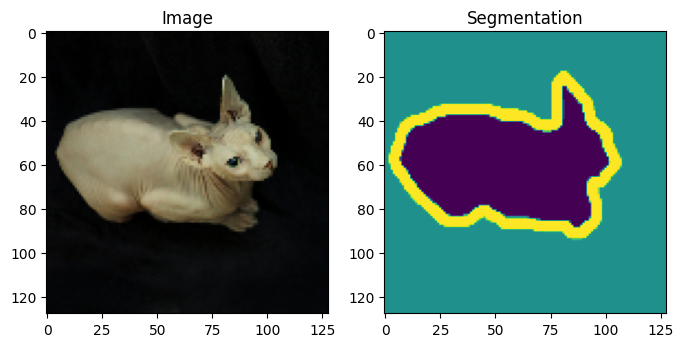

In [10]:
# Printing the example
for example in train:
    image, mask = example[0], example[1]
    print(f'{image.shape} is the shape of the input image')
    print(f'{mask.shape} is the shape of the mask image')
    fig, arr = plt.subplots(1, 2, figsize=(8, 7))
    arr[0].imshow(image)
    arr[0].set_title('Image')
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    break

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [12]:
# Preparing the batched data for training
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [13]:
# Finding number of classes
for example in train.take(1):
    _, mask = example[0], example[1]
    unique_classes = np.unique(tfds.as_numpy(mask))
    n_classes = len(unique_classes)
    print(f"Unique classes in segmentation mask: {unique_classes}")
    print(f"Number of classes: {n_classes}")

Unique classes in segmentation mask: [0.         0.00439453 0.03125    0.04833984 0.05419922 0.11474609
 0.12451172 0.14013672 0.15625    0.1772461  0.21875    0.22021484
 0.22705078 0.25830078 0.26904297 0.28125    0.28466797 0.28564453
 0.29052734 0.32958984 0.3383789  0.35595703 0.40625    0.53125
 0.59375    0.74072266 0.78125    0.81884766 0.8491211  0.96875
 1.         1.013916   1.0310059  1.0402832  1.0500488  1.0598145
 1.072998   1.0769043  1.078125   1.1008301  1.107666   1.1154785
 1.1459961  1.1491699  1.15625    1.1691895  1.171875   1.1901855
 1.1950684  1.203125   1.2043457  1.213623   1.2512207  1.265625
 1.277832   1.2834473  1.295166   1.2954102  1.3227539  1.328125
 1.34375    1.359375   1.3757324  1.4294434  1.4475098  1.4477539
 1.4506836  1.453125   1.46875    1.4836426  1.484375   1.4855957
 1.4870605  1.4897461  1.515625   1.53125    1.5327148  1.557373
 1.578125   1.5808105  1.5837402  1.640625   1.6506348  1.65625
 1.6831055  1.685791   1.6918945  1.7097168  

### U-Net Architechture Design

#### Encoder Block Design

In [14]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                3,   # Kernel size
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(inputs)

    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)


    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

#### Decoder Block Design

In [15]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                n_filters, # number of filters
                3,    # Kernel size
                strides=2,
                padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    return conv

#### Building the model

In [16]:
def unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=122):
    inputs = Input(input_size)
    # Contracting Path (encoding)

    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)

    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3)

    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [17]:
img_height = 128
img_width = 128
num_channels = 3
# Intializing the model
unet = unet_model((img_height, img_width, num_channels))

#### Compiling the model

In [18]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#### Training the model

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
def display(display_list):
    plt.figure(figsize=(8,8))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [22]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

(128, 128, 1)


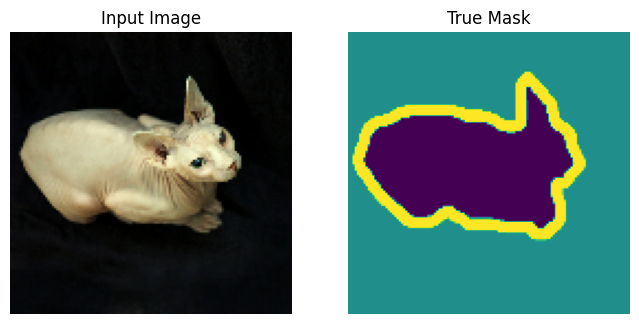

In [23]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

1/1 [==============================] - 0s 36ms/step


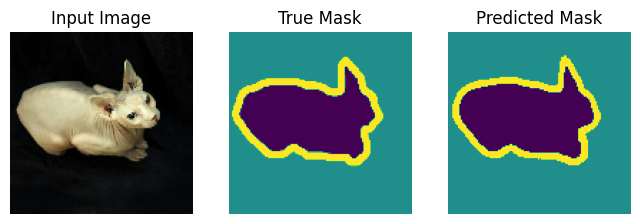


Sample Prediction after epoch 25

115/115 [==============================] - 41s 358ms/step - loss: 0.1678 - accuracy: 0.9253 - val_loss: 0.3933 - val_accuracy: 0.8695


In [29]:
model_history = unet.fit(train_dataset, epochs = 25, steps_per_epoch = STEPS_PER_EPOCH, validation_data = test_dataset, callbacks=[DisplayCallback()])

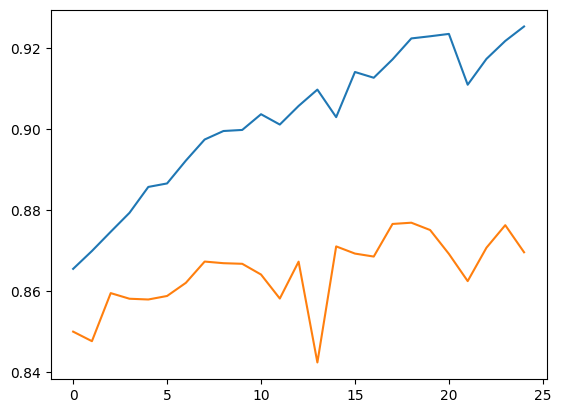

In [30]:
import matplotlib.pyplot as plt
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

### Making Prediction

### Visualizing the Result

1/1 [==============================] - 0s 98ms/step


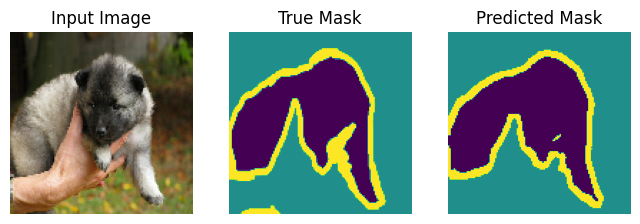

1/1 [==============================] - 0s 39ms/step


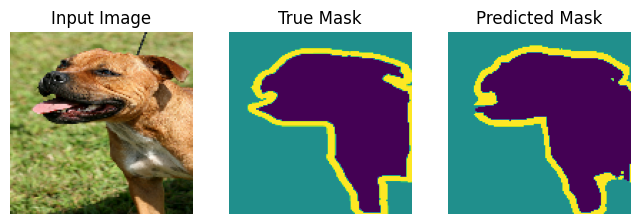

1/1 [==============================] - 0s 29ms/step


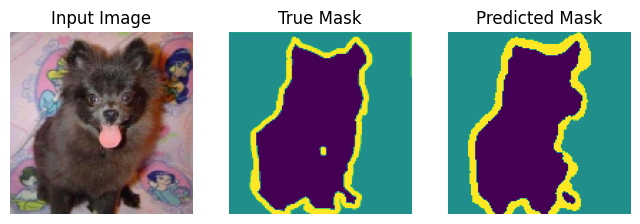

1/1 [==============================] - 0s 73ms/step


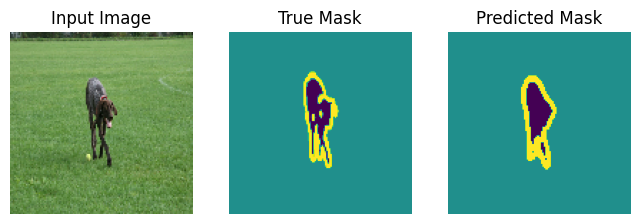

1/1 [==============================] - 0s 24ms/step


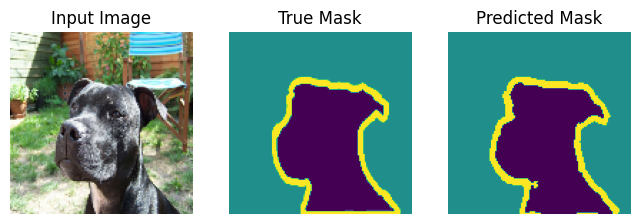

1/1 [==============================] - 0s 23ms/step


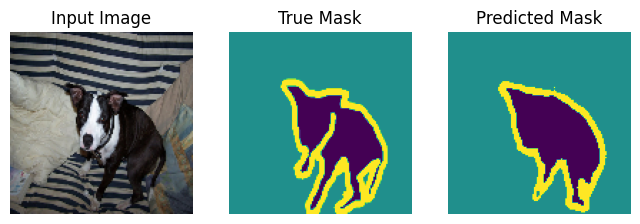

In [31]:
show_predictions(train_dataset, 6)